In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# BaristaBot – Créer un agent conversationnel structuré avec LangGraph & Gemini

Dans ce projet nous allons créer **BaristaBot**, un assistant IA capable de prendre des commandes de café en langage naturel 🗣️. Ce bot est construit autour d’un **graphe conversationnel dynamique** combinant les puissances de **LangGraph**, **LangChain** et **l’API Gemini de Google**.

---

### Objectifs du projet

1. **Créer une application avec état** : chaque échange avec le client modifie ou enrichit un état structuré (`OrderState`), qui suit toute la conversation.
2. **Utiliser un LLM dans une architecture contrôlée** : via LangGraph, nous définissons chaque transition, condition, et logique métier sans laisser le LLM tout contrôler.
3. **Intégrer des outils personnalisés** : pour afficher un menu, ajouter des produits à la commande, valider ou effacer le panier, etc.
4. **Gérer une boucle conversationnelle réaliste** : du bonjour jusqu'à l'envoi de la commande en cuisine.

---

> Le résultat final est un assistant réaliste et interactif, capable de simuler un système de commande en café avec un comportement personnalisé et une logique d’état robuste.

In [2]:
# Install required libraries (silent)
%pip install -qU 'langgraph==0.2.45' 'langchain-google-genai==2.0.4'
print(" Libraries installed successfully.")


Note: you may need to restart the kernel to use updated packages.
 Libraries installed successfully.


In [23]:
import os
from kaggle_secrets import UserSecretsClient

# Chargement de la clé Gemini depuis les secrets
GOOGLE_API_KEY = UserSecretsClient().get_secret("APi_AI_Studio")
os.environ["APi_AI_Studio"] = GOOGLE_API_KEY

# Eviter la détection automatique GCP
os.environ["GOOGLE_CLOUD_PROJECT"] = "dummy-project"

print(" Gemini API key loaded.")


 Gemini API key loaded.


 ## 1. Définition des outils du BaristaBot

 Pour rendre le bot intelligent et interactif, nous allons ajouter des outils (functions) qu’il pourra appeler dynamiquement :

- `get_menu` : Affiche le menu actuel.
- `add_to_order` : Ajoute un élément à la commande.
- `clear_order` : Réinitialise la commande.
- `confirm_order` : Demande à l’utilisateur de valider sa commande.
- `place_order` : Finalise la commande.

Ces outils seront appelés automatiquement par Gemini grâce au mécanisme `ToolNode` de LangGraph.


    

### Mise en place complète du bot et des outils

#### Définir l'état OrderState, l'instruction système, et le message d'accueil

In [24]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

# Structure de l'état global transmis dans le graphe
class OrderState(TypedDict):
    """State representing the customer's order conversation."""
    messages: Annotated[list, add_messages]  # Conversation history
    order: list[str]                          # In-progress drink order
    finished: bool                            # Flag to end the loop

#  Instruction système : définit le comportement du chatbot
BARISTABOT_SYSINT = (
    "system",
    "You are a BaristaBot, an interactive cafe ordering system. A human will talk to you about the "
    "available products you have and you will answer any questions about menu items (and only about "
    "menu items - no off-topic discussion, but you can chat about the products and their history). "
    "The customer will place an order for 1 or more items from the menu, which you will structure "
    "and send to the ordering system after confirming the order with the human. "
    "\n\n"
    "Add items to the customer's order with add_to_order, and reset the order with clear_order. "
    "To see the contents of the order so far, call get_order (this is shown to you, not the user). "
    "Always confirm_order with the user (double-check) before calling place_order. "
    "Calling confirm_order will display the order items to the user and returns their response to seeing the list. "
    "Their response may contain modifications. "
    "Always verify and respond with drink and modifier names from the MENU before adding them to the order. "
    "You only have the modifiers listed on the menu. "
    "Once the customer has finished ordering items, Call confirm_order to ensure it is correct then make "
    "any necessary updates and then call place_order. Once place_order has returned, thank the user and "
    "say goodbye!"
)

#  Message d'accueil initial
WELCOME_MSG = " Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?"


#### Définition du Menu

In [25]:
# Simulated menu (can be replaced by dynamic loading)
MENU = [
    "latte", "cappuccino", "americano", "espresso",
    "chai tea", "green tea", "black tea",
    "oat milk", "almond milk", "soy milk", "whole milk"
]

def get_menu() -> str:
    return "\n".join(MENU)

#### Définir les fonctions/outils de commande

In [26]:
# Outil : ajoute un élément à la commande
def add_to_order(state: OrderState, item: str) -> OrderState:
    if item in MENU:
        state["order"].append(item)
    else:
        state["messages"].append({"role": "assistant", "content": f"Sorry, we don't have '{item}' on the menu."})
    return state

# Outil : efface la commande en cours
def clear_order(state: OrderState) -> OrderState:
    state["order"] = []
    return stat

# Outil : confirme la commande avec l’utilisateur
def confirm_order(state: OrderState) -> OrderState:
    order_items = ", ".join(state["order"])
    state["messages"].append({"role": "assistant", "content": f"You're about to order: {order_items}. Is that correct?"})
    return state

# Outil : finalise la commande
def place_order(state: OrderState) -> OrderState:
    if not state["order"]:
        state["messages"].append({"role": "assistant", "content": "You have no items in your order yet!"})
    else:
        state["finished"] = True
        state["messages"].append({"role": "assistant", "content": "✅ Your order has been placed. Thank you and enjoy your drink!"})
    return state


 #### Tester une exécution manuelle 

In [27]:
# Exemple d'état initial
state = {
    "messages": [{"role": "user", "content": "I want a latte and almond milk"}],
    "order": [],
    "finished": False
}

# Test manuel (exemple d'ajout)
state = add_to_order(state, "latte")
state = add_to_order(state, "almond milk")
state = confirm_order(state)
state = place_order(state)

# Affiche les messages générés
for msg in state["messages"]:
    print(f"{msg['role'].capitalize()}: {msg['content']}")


User: I want a latte and almond milk
Assistant: You're about to order: latte, almond milk. Is that correct?
Assistant: ✅ Your order has been placed. Thank you and enjoy your drink!


## Définir un chatbot à tour unique

In [34]:
# LangGraph nous permet de modéliser des étapes de dialogue en tant que "nœuds" dans un graphe d'état.
# Ici, nous définissons un chatbot simple (1 seul échange) à partir de notre modèle Gemini.

from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI

# Initialisation explicite du modèle Gemini avec clé API pour éviter les problèmes sur Kaggle
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash-latest",
    google_api_key=os.environ["APi_AI_Studio"],
)


# 💬 Fonction du chatbot : génère une réponse à partir de l'historique de conversation
def chatbot(state: OrderState) -> OrderState:
    """
    Ce nœud représente une interaction unique avec le chatbot.
    Il utilise l'historique des messages, applique les instructions système, 
    puis ajoute la réponse générée à l'état.
    """
    message_history = [BARISTABOT_SYSINT] + state["messages"]
    return {"messages": [llm.invoke(message_history)]}


#### Construction du graphe avec un seul nœud

In [35]:
# Création du graphe LangGraph avec un seul nœud : le chatbot

# StateGraph : un graphe d’état LangGraph basé sur notre schéma OrderState
graph_builder = StateGraph(OrderState)

# Ajout du nœud chatbot
graph_builder.add_node("chatbot", chatbot)

# L'entrée (START) va vers le chatbot, qui termine directement (END)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# Compilation du graphe en une application exécutable
chat_graph = graph_builder.compile()


####  Visualisation du graphe

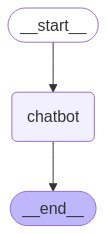

In [36]:
# Visualisation du graphe : cela permet de voir les transitions entre nœuds
from IPython.display import Image

# Affiche une image Mermaid du graphe (utile pour comprendre la structure)
Image(chat_graph.get_graph().draw_mermaid_png())


## Exécution du graphe (1er tour de chat)

In [37]:
# On initialise l’état avec un message utilisateur.
from pprint import pprint
from langchain_core.messages import HumanMessage

# L'utilisateur passe sa première commande
user_msg = HumanMessage(content="Hi! I'd like a cappuccino with oat milk please.")

# Création de l'état initial avec ce message utilisateur
state = chat_graph.invoke({"messages": [user_msg], "order": [], "finished": False})

# Affiche l'état complet
# pprint(state)

# Affiche les messages de la conversation (entrée + réponse du bot)
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")


HumanMessage: Hi! I'd like a cappuccino with oat milk please.
AIMessage: We have a delicious cappuccino!  We offer oat milk as a dairy alternative.  Is there anything else I can get for you?



In [38]:
# Étape 7 : ajouter une interaction manuellement
from langchain_core.messages import HumanMessage

# Ajouter une nouvelle requête à l'historique
user_msg = "Actually, make it two cappuccinos and one chai latte."
state["messages"].append(HumanMessage(content=user_msg))

# Réinvoquer le graphe avec l'état mis à jour
state = chat_graph.invoke(state)

# Affichage de la conversation mise à jour
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")


HumanMessage: Hi! I'd like a cappuccino with oat milk please.
AIMessage: We have a delicious cappuccino!  We offer oat milk as a dairy alternative.  Is there anything else I can get for you?

HumanMessage: Actually, make it two cappuccinos and one chai latte.
AIMessage: Okay, two cappuccinos and one chai latte.  Anything else?



### Ajouter un nœud humain et une boucle de conversation

Pour permettre une véritable conversation entre l'utilisateur et le chatbot, nous ajoutons un **nœud "humain"**. Celui-ci affiche la réponse du modèle, puis recueille une nouvelle entrée de l’utilisateur. Ensuite, le graphe retourne vers le chatbot, créant ainsi une boucle naturelle.

Cette architecture permettra plus tard de sortir de la boucle en cas de commande finalisée.


In [39]:
from langchain_core.messages.ai import AIMessage

# Noeud humain : affiche le message IA et recueille l'entrée utilisateur
def human_node(state: OrderState) -> OrderState:
    """Display the last model message to the user, and receive the user's input."""
    last_msg = state["messages"][-1]
    print(" Model:", last_msg.content)

    user_input = input("User: ")

    # Si l'utilisateur tape une commande d'arrêt, on termine la session
    if user_input.lower() in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}

# Noeud chatbot avec message de bienvenue intégré
def chatbot_with_welcome_msg(state: OrderState) -> OrderState:
    """Gemini-powered chatbot with a welcome message if it's the first interaction."""
    if state["messages"]:
        # Conversation en cours
        new_output = llm.invoke([BARISTABOT_SYSINT] + state["messages"])
    else:
        # Démarrage de la conversation avec un message d'accueil
        new_output = AIMessage(content=WELCOME_MSG)

    return state | {"messages": [new_output]}


#### Création du graphe avec deux nœuds (chatbot ↔ humain)

In [40]:
from langgraph.graph import StateGraph, START

# Nouvelle instance du graphe
graph_builder = StateGraph(OrderState)

# Déclaration des deux nœuds
graph_builder.add_node("chatbot", chatbot_with_welcome_msg)
graph_builder.add_node("human", human_node)

# Début du graphe = chatbot
graph_builder.add_edge(START, "chatbot")

# Après chaque réponse du chatbot → demande à l'utilisateur
graph_builder.add_edge("chatbot", "human")

# (prochaine étape : retour de l'utilisateur vers le chatbot avec condition)


#### Ajouter une condition de sortie pour éviter une boucle infinie

Fonction de routage conditionnel + compilation du graphe

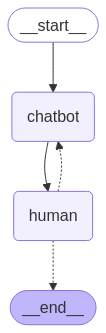

In [41]:
from typing import Literal
from IPython.display import Image

# Fonction conditionnelle : retour au chatbot ou fin du graphe
def maybe_exit_human_node(state: OrderState) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
        return END
    else:
        return "chatbot"

# Ajout d’une arête conditionnelle human → chatbot OU END
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Compilation finale du graphe conversationnel
chat_with_human_graph = graph_builder.compile()

# Visualisation du graphe LangGraph
Image(chat_with_human_graph.get_graph().draw_mermaid_png())


### Intégration d’un menu dynamique avec un outil

Nous allons créer un outil `get_menu()` qui fournit un menu à jour.  
Cet outil est de type **stateless** (sans état) et peut être appelé automatiquement par le modèle Gemini si besoin.

Une fois l’outil défini, on l’ajoute à un `ToolNode`, puis on met à jour :
- le modèle LLM (`llm.bind_tools(...)`) pour qu’il en prenne conscience
- la logique du graphe avec une condition `maybe_route_to_tools`

Enfin, on affiche le graphe enrichi de ce nouvel outil.


In [56]:
from langchain_core.tools import tool
from collections.abc import Iterable

# Définition des outils liés à la commande, sous forme de stubs
@tool
def add_to_order(drink: str, modifiers: Iterable[str]) -> str:
    """Adds the specified drink to the customer's order, including any modifiers."""
    pass

@tool
def confirm_order() -> str:
    """Asks the customer if the order is correct."""
    pass

@tool
def get_order() -> str:
    """Returns the user's order so far. One item per line."""
    pass

@tool
def clear_order():
    """Removes all items from the user's order."""
    pass

@tool
def place_order() -> int:
    """Sends the order to the barista for fulfillment and returns ETA."""
    pass


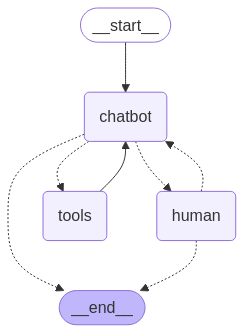

In [62]:
from langgraph.prebuilt import ToolNode


# Define the tools and create a "tools" node.
tools = [get_menu]
tool_node = ToolNode(tools)

# Attach the tools to the model so that it knows what it can call.
llm_with_tools = llm.bind_tools(tools)


def maybe_route_to_tools(state: OrderState) -> str:
    """Route entre chatbot, tools, ordering ou human selon les outils appelés."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    msg = msgs[-1]

    if state.get("finished", False):
        return END

    elif hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        # Si l'un des outils invoqués appartient aux outils de commande → ordering
        if any(tool["name"] in [t.name for t in order_tools] for tool in msg.tool_calls):
            return "ordering"
        else:
            return "tools"

    else:
        return "human"

def chatbot_with_tools(state: OrderState) -> OrderState:
    """The chatbot with tools. A simple wrapper around the model's own chat interface."""
    defaults = {"order": [], "finished": False}

    if state["messages"]:
        new_output = llm_with_tools.invoke([BARISTABOT_SYSINT] + state["messages"])
    else:
        new_output = AIMessage(content=WELCOME_MSG)

    # Set up some defaults if not already set, then pass through the provided state,
    # overriding only the "messages" field.
    return defaults | state | {"messages": [new_output]}


graph_builder = StateGraph(OrderState)

# Add the nodes, including the new tool_node.
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)

# Chatbot may go to tools, or human.
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human may go back to chatbot, or exit.
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")

graph_builder.add_edge(START, "chatbot")
graph_with_menu = graph_builder.compile()

Image(graph_with_menu.get_graph().draw_mermaid_png())


###  Gestion des commandes dans BaristaBot

À ce stade, notre chatbot peut discuter avec l'utilisateur et appeler des outils comme `get_menu`.  
Mais il doit désormais **gérer des commandes réelles** : stocker les boissons demandées, appliquer des modifications (modifiers), confirmer, annuler ou valider une commande.

Dans cette étape, nous allons :

- Définir de nouveaux outils liés aux commandes (comme `add_to_order`, `clear_order`, `confirm_order`, etc.)
- Implémenter un nœud `ordering` spécifique qui gère l’état de la commande dans le graphe.
- Faire en sorte que l'IA appelle ces outils dans la conversation, sans jamais modifier directement l’état (par sécurité et clarté).

Ces outils sont définis comme des stubs (fonctions sans corps) uniquement pour exposer leur schéma au LLM.  
Le traitement réel est délégué au nœud `order_node`.

**Objectif** : Simuler un vrai système de commande de café, avec une logique métier contrôlée côté serveur.


In [63]:
from langchain_core.tools import tool

@tool
def get_menu() -> str:
    """Provide the latest up-to-date menu of drinks and modifiers."""
    return """
    MENU:
    Coffee Drinks:
    Espresso
    Americano
    Cold Brew

    Coffee Drinks with Milk:
    Latte
    Cappuccino
    Cortado
    Macchiato
    Mocha
    Flat White

    Tea Drinks:
    English Breakfast Tea
    Green Tea
    Earl Grey

    Tea Drinks with Milk:
    Chai Latte
    Matcha Latte
    London Fog

    Other Drinks:
    Steamer
    Hot Chocolate

Modifiers:
    Milk options: Whole, 2%, Oat, Almond, 2% Lactose Free; Default option: whole
    Espresso shots: Single, Double, Triple, Quadruple; default: Double
    Caffeine: Decaf, Regular; default: Regular
    Hot-Iced: Hot, Iced; Default: Hot
    Sweeteners: vanilla, hazelnut, caramel, chocolate, sugar-free vanilla
    Special: 'extra hot', 'one pump', 'half caff', 'extra foam'

Note: Soy milk is out of stock today.
    """



In [64]:
from random import randint
from langchain_core.messages.tool import ToolMessage

def order_node(state: OrderState) -> OrderState:
    """Nœud de gestion des commandes : applique les effets des outils appelés."""
    tool_msg = state["messages"][-1]
    order = state.get("order", [])
    outbound_msgs = []
    order_placed = False

    for tool_call in tool_msg.tool_calls:
        name = tool_call["name"]
        args = tool_call.get("args", {})
        tool_id = tool_call["id"]

        if name == "add_to_order":
            modifiers = args.get("modifiers", [])
            drink = args.get("drink", "")
            mod_str = ", ".join(modifiers) if modifiers else "no modifiers"
            order.append(f"{drink} ({mod_str})")
            response = "\n".join(order)

        elif name == "confirm_order":
            print("Your order:")
            for drink in order:
                print(f"  {drink}")
            response = input("Is this correct? ")

        elif name == "get_order":
            response = "\n".join(order) if order else "(no order)"

        elif name == "clear_order":
            order.clear()
            response = None

        elif name == "place_order":
            print("Sending order to kitchen!")
            print("\n".join(order))
            order_placed = True
            response = randint(1, 5)  # minutes

        else:
            raise NotImplementedError(f"Unknown tool call: {name}")

        # Enregistre les résultats comme ToolMessage
        outbound_msgs.append(
            ToolMessage(content=response, name=name, tool_call_id=tool_id)
        )

    return {
        "messages": outbound_msgs,
        "order": order,
        "finished": order_placed
    }


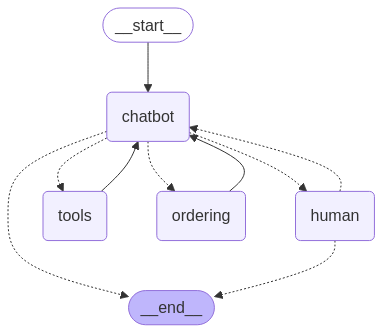

In [65]:
### Définir le graphe complet avec gestion de commandes

# Outils automatiques (peuvent être appelés automatiquement par le LLM)
auto_tools = [get_menu]
tool_node = ToolNode(auto_tools)

# Outils de gestion des commandes (traités par un nœud spécifique `order_node`)
order_tools = [add_to_order, confirm_order, get_order, clear_order, place_order]

# Le LLM doit connaître tous les outils qu’il peut appeler
llm_with_tools = llm.bind_tools(auto_tools + order_tools)

# Création du graphe avec tous les nœuds nécessaires
graph_builder = StateGraph(OrderState)

# Nœuds du graphe
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("ordering", order_node)  # le nœud qui gère les modifications de commandes

# Transitions conditionnelles

# Le chatbot peut diriger vers : outils automatiques, outils de commande, humain ou fin
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)

# Le nœud humain peut soit retourner vers le chatbot, soit terminer la conversation
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Les outils retournent toujours vers le chatbot
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("ordering", "chatbot")

# Démarrage du graphe
graph_builder.add_edge(START, "chatbot")

# Compilation finale du graphe
graph_with_order_tools = graph_builder.compile()

# Affichage visuel du graphe
from IPython.display import Image
Image(graph_with_order_tools.get_graph().draw_mermaid_png())


In [67]:
###  Définir le graphe complet avec gestion de commandes

# Outils automatiques (peuvent être appelés automatiquement par le LLM)
auto_tools = [get_menu]
tool_node = ToolNode(auto_tools)

# Outils de gestion des commandes (traités par un nœud spécifique `order_node`)
order_tools = [add_to_order, confirm_order, get_order, clear_order, place_order]

# Le LLM doit connaître tous les outils qu’il peut appeler
llm_with_tools = llm.bind_tools(auto_tools + order_tools)

# Création du graphe avec tous les nœuds nécessaires
graph_builder = StateGraph(OrderState)

# Nœuds du graphe
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("ordering", order_node)  # le nœud qui gère les modifications de commandes



In [68]:
# Transitions conditionnelles
# Le chatbot peut aller vers : tools, ordering, human ou END
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)

# Le nœud humain peut aller vers : chatbot ou END (si l'utilisateur quitte)
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Transitions fixes
# Une fois un outil exécuté (get_menu), on retourne au chatbot
graph_builder.add_edge("tools", "chatbot")

# Une fois une commande modifiée ou confirmée, retour au chatbot
graph_builder.add_edge("ordering", "chatbot")

# Le point de départ du graphe est le chatbot
graph_builder.add_edge(START, "chatbot")


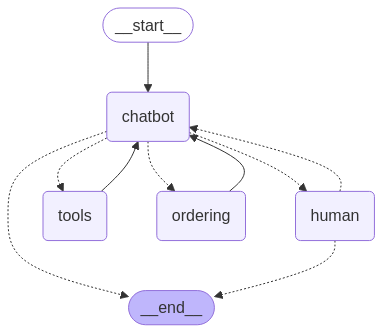

In [69]:
graph_with_order_tools = graph_builder.compile()

# Affichage du graphe sous forme de diagramme Mermaid
from IPython.display import Image
Image(graph_with_order_tools.get_graph().draw_mermaid_png())


In [70]:
from pprint import pprint

# On augmente la profondeur autorisée du graphe pour permettre plusieurs échanges
config = {"recursion_limit": 100}

# Lancement de l'assistant BaristaBot avec un état initial vide
state = graph_with_order_tools.invoke({"messages": []}, config)

# Affichage du dernier état de la conversation (commande, messages, etc.)
pprint(state)


 Model:  Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?


User:  I would like a coffee with milk


 Model: We have a variety of coffees.  Do you have a preference (e.g., Americano, Latte, Espresso)?  And by milk, do you mean regular milk, oat milk, almond milk, or soy milk?



User:  I would like a Latte coffee with regular milk


 Model: Okay, one Latte with regular milk. Anything else?





User:  yes, with sugar 


 Model: I'm sorry, we don't have sugar as a modifier for Latte. Would you like any other additions?





User:  No, thanks


 Model: Okay, so you would like one Latte with regular milk. Is that correct?





User:  yes


Your order:
  Latte (regular milk)


Is this correct?  yes


Sending order to kitchen!
Latte (regular milk)
{'finished': True,
 'messages': [AIMessage(content=' Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?', additional_kwargs={}, response_metadata={}, id='857a2deb-931d-417a-9a3c-0523df6c7213'),
              HumanMessage(content='I would like a coffee with milk', additional_kwargs={}, response_metadata={}, id='03c135ab-4201-4dff-8cfc-110adfc9f17a'),
              AIMessage(content='We have a variety of coffees.  Do you have a preference (e.g., Americano, Latte, Espresso)?  And by milk, do you mean regular milk, oat milk, almond milk, or soy milk?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-f03fc509-57dc-45cc-a2f3-a878d0d0bc39-0', usage_metadata={'input_tokens': 389, 'output_tokens': 46, 'total_tokens': 435, 'input_token_details': {'cache_read': 0}}),
              HumanMessage(content='I would lik

## Conclusion

Nous avons construit un agent conversationnel **intelligent, interactif et modulaire** grâce à **LangGraph** et **Gemini** :

- Il est capable de **comprendre des demandes clients complexes** et de s’y adapter.
- Il sait **appeler dynamiquement les bons outils** (menu, confirmation, ajout...) selon le besoin.
- Il **maintient un état conversationnel clair**, ce qui garantit une logique fluide et sans incohérences.
- Et surtout : il **boucle naturellement la discussion** jusqu’à la finalisation de la commande.